## Author: Himaja R. Ginkala

## Description: Compares multiple deep learning models for classifying benign and malignant skin cancer images.

In [8]:
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models

from analysis_utils import generate_classification_report, plot_roc_curve, plot_train_loss_accuracy
from data_loader import load_data
from model_utils import train_model, validate_model, test_model

Class Indices: {'Benign': 0, 'Malignant': 1}
Number of Training Samples: 9503
Number of Validation Samples: 2376
Number of Test Samples: 2000


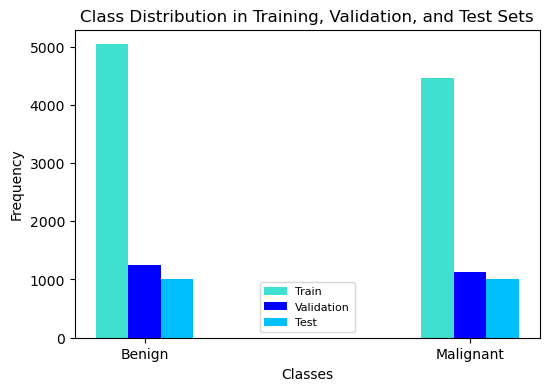

In [9]:
# load data
train_loader, val_loader, test_loader, class_names = load_data(batch_size=32)

### Model Definitions

In [10]:
resNet = {
    'name': 'ResNet-18',
    'model': models.resnet18(pretrained=True),
    'num_features': lambda model: model.fc.in_features,
    'final_layer': lambda model, num_classes: nn.Linear(model.fc.in_features, num_classes)
}

uNet = {
    'name': 'UNet',
    'model': smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=2),
    'num_features': None,
    'final_layer': None
}

### Model Execution

In [11]:
EPOCHS = 5
LEARNING_RATE = 0.001

In [12]:
# dictionaries to store results
all_train_losses = {}
all_train_accuracies = {}

all_val_losses = {}
all_val_accuracies = {}

all_true_labels = {}
all_predictions = {}

In [13]:
def run_model(model_info):
    """
    
    """
    
    model_name = model_info['name']
    model = model_info['model']
    
    # modify final layer for classification and match number of classes
    if model_info['final_layer'] is not None:
        num_features = model_info['num_features'](model)
        model.fc = model_info['final_layer'](model, 2)

    # move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # define loss function ands optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # train and validate model
    print(f'Training {model_name}...')
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=EPOCHS)
     
    # test model
    print(f'Testing {model_name}...')
    test_loss, accuracy, true_labels, predictions = test_model(model, test_loader, criterion, device)

    all_train_losses[model_name] = train_losses
    all_train_accuracies[model_name] = train_accuracies

    all_val_losses[model_name] = val_losses
    all_val_accuracies[model_name] = val_accuracies

    all_true_labels[model_name] = true_labels
    all_predictions[model_name] = predictions

    return train_accuracies, train_losses, val_losses, val_accuracies, true_labels, predictions

#### Running ResNet-18

In [14]:
train_accuracies, train_losses, val_losses, val_accuracies, true_labels, predictions = run_model(model_info=resNet)

Training ResNet-18...


Epoch 5/5: 100%|██████████| 297/297 [13:38<00:00,  2.76s/it, loss=0.2644]


Testing ResNet-18...


Testing: 100%|██████████| 63/63 [00:46<00:00,  1.37it/s]

Test Loss: 0.2494, Accuracy: 90.20%


#### Running UNet

In [15]:
# train_accuracies, train_losses, val_losses, val_accuracies, true_labels, predictions = run_model(model_info=uNet)

### Results


Classification Report:
              precision    recall  f1-score   support

      Benign       0.86      0.95      0.91      1000
   Malignant       0.95      0.85      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.90      0.90      2000


Confusion Matrix:
[[955  45]
 [151 849]]


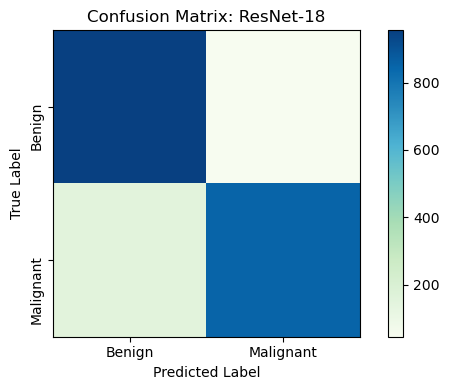

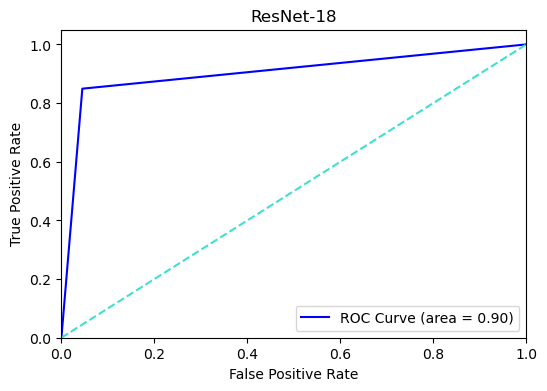

In [20]:
generate_classification_report(all_true_labels[resNet['name']], all_predictions[resNet['name']], class_names, resNet['name'])
plot_roc_curve(all_true_labels[resNet['name']], all_predictions[resNet['name']], resNet['name'])